# Torchvision을 이용한 돼지 초음파 영상 데이터셋에서의 객체 검출

## 00. 구글드라이브 연동

구글 드라이브에 데이터셋을 업로드한 후에 진행합니다.

구글 드라이브에 업로드할 때는 압축을 해제한 상태로 폴더 째로 업로드해주세요

In [ ]:
# 라이브러리 import
from google.colab import drive
# 구글 드라이브 마운트
drive.mount('./gdrive')

Mounted at ./gdrive


**작업 공간으로 이동**

- 작업의 편의성을 위해 데이터가 저장된 경로 가까이로 이동해서 작업합니다.
- 이 코드는 데이터 디렉토리의 상위폴더를 기준으로 작성되었습니다.

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/rda-colab/') # 데이터 폴더를 업로드한 경로를 입력해주세요.
!pwd

/content/gdrive/MyDrive/rda-colab


In [ ]:
!ls # 데이터 폴더 이름이 출력되어야 합니다.

 preprocessed_data.csv	'데이터 설명.pdf'   양돈과_최요한
 낙농과_박성민		 양돈과_백수현	    한우연_박명선_대사각인1차.xlsx


**데이터셋 구조 확인**

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (162 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree 양돈과_최요한

양돈과_최요한
├── 19_1
│   ├── 21-2_frame0.bmp
│   ├── 21-2_frame10.bmp
│   ├── 21-2_frame11.bmp
│   ├── 21-2_frame12.bmp
│   ├── 21-2_frame13.bmp
│   ├── 21-2_frame14.bmp
│   ├── 21-2_frame15.bmp
│   ├── 21-2_frame15.txt
│   ├── 21-2_frame16.bmp
│   ├── 21-2_frame17.bmp
│   ├── 21-2_frame17.txt
│   ├── 21-2_frame18.bmp
│   ├── 21-2_frame19.bmp
│   ├── 21-2_frame19.txt
│   ├── 21-2_frame1.bmp
│   ├── 21-2_frame20.bmp
│   ├── 21-2_frame20.txt
│   ├── 21-2_frame21.bmp
│   ├── 21-2_frame21.txt
│   ├── 21-2_frame22.bmp
│   ├── 21-2_frame22.txt
│   ├── 21-2_frame23.bmp
│   ├── 21-2_frame24.bmp
│   ├── 21-2_frame25.bmp
│   ├── 21-2_frame26.bmp
│   ├── 21-2_frame27.bmp
│   ├── 21-2_frame28.bmp
│   ├── 21-2_frame29.bmp
│   ├── 21-2_frame2.bmp
│   ├── 21-2_frame30.bmp
│   ├── 21-2_frame31.bmp
│   ├── 21-2_frame32.bmp
│   ├── 21-2_frame33.bmp
│   ├── 21-2_frame34.bmp
│   ├── 21-2_frame35.bmp
│   ├── 21-2_frame36.bmp
│   ├── 21-2_frame37.bmp
│   ├── 21-2_frame38.bmp
│   ├── 21-2_frame39.bmp
│   ├── 21-

In [ ]:
!cat 양돈과_최요한/19_1/21-2_frame15.txt

0 0.455078 0.384722 0.053906 0.063889
0 0.438672 0.482639 0.071094 0.098611


## 01. 데이터셋 정의

현재 데이터셋은
* bmp 이미지
* YOLO 형식의 레이블링
* 1개 클래스
* 레이블이 없는 이미지 존재

PyTorch에서 사용할 수 있도록 데이터셋을 정의하는 코드를 작성해줍니다.

레이블 파일이 없는 이미지는 버립니다.


In [ ]:
import glob
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class PigDataset(Dataset):
    def __init__(self, root_dir):
        """
        데이터셋 정의 클래스
        Args:
            root_dir (str): 데이터셋 경로. '양돈과_최요한' 데이터는 내부에 여러 서브폴더가 있습니다.
        """

        #  1) glob으로 모든 BMP 파일 찾기
        # 예시 패턴: '/content/양돈과_최요한/*/*.bmp'
        pattern = os.path.join(root_dir, '*', '*.bmp')
        all_bmp_paths = glob.glob(pattern)

        #  2) 레이블(.txt) 파일이 있는 경우만 남기기
        self.img_files = []
        for bmp_path in all_bmp_paths:
            # 이미지 파일 경로에서 확장자만 .txt로 바꿔서 레이블 경로 생성
            txt_path = bmp_path[:-4] + '.txt'
            # 레이블 파일이 실제로 존재할 때만 리스트에 포함
            if os.path.exists(txt_path):
                self.img_files.append(bmp_path)
        # self.img_files에는 .bmp/.txt 쌍만 남김

    def __len__(self):
        # 데이터셋 크기(이미지 수)를 반환합니다.
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        idx번째 샘플(이미지+타깃)을 반환합니다.
        Returns:
            img (Tensor): transform이 적용된 이미지
            target (dict): {'boxes': Tensor[N,4], 'labels': Tensor[N]} 어노테이션
        """
        # 1) 이미지 열기
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert("RGB")
        width, height = img.size  # 이미지 크기 가져오기

        # 2) 어노테이션(.txt) 읽기 (YOLO 포맷)
        txt_path = img_path[:-4] + '.txt'
        boxes, labels = [], []
        with open(txt_path, 'r') as f:
            for line in f:
                # 예: "0 0.5 0.5 0.2 0.2"
                cls, x_c, y_c, w, h = map(float, line.strip().split())

                # 정규화된 중심 좌표 → 실제 픽셀 좌표로 변환
                x1 = (x_c - w / 2) * width
                y1 = (y_c - h / 2) * height
                x2 = (x_c + w / 2) * width
                y2 = (y_c + h / 2) * height

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls)+1) # torchvison에서는 0은 배경으로 고정이기 때문에 클래스 번호 + 1

        # 3) 이미지와 박스 레이블 리사이즈
        new_size= (224,224)
        scale_x = new_size[0] / width
        scale_y = new_size[1] / height

        # 이미지 리사이즈
        img = img.resize(new_size)

        # 박스 리사이즈
        boxes = [[box[0] * scale_x, box[1] * scale_y, box[2] * scale_x, box[3] * scale_y] for box in boxes]

        # 4) Tensor로 변환
        img = transforms.ToTensor()(img)

        # 리스트가 빈 경우에도 올바른 shape 생성
        # 빈 레이블 파일이 존재합니다. 레이블 파일을 확인하세요.
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32) # [0,4]
            labels = torch.zeros((0,), dtype=torch.int64)    # [0]
        else:
          boxes  = torch.tensor(boxes, dtype=torch.float32)  # [N,4]
          labels = torch.tensor(labels, dtype=torch.int64)   # [N]

        # 5) 모델 입력 형식에 맞는 딕셔너리 생성
        target = {
            'boxes':  boxes,   # 박스 좌표 정보
            'labels': labels   # 박스별 클래스 ID
        }

        return img, target

위 코드는 어려울 수 있습니다.

코드를 이해하지 못하더라도 **클래스 이름 데이터셋 구조, 데이터 확장자, 레이블 유형** 등만 파악하고 수정해주면 커스텀 데이터셋을 PyTorch에서 쓸 수 있게 가져올 수 있습니다.

정의된 데이터셋을 사용은 다음과 같습니다.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

# 1) 이미지 전처리(데이터셋 정의 과정에 포함)

# 2) 데이터셋 로드
dataset = PigDataset('/content/gdrive/MyDrive/rda-colab/양돈과_최요한')

# 3) DataLoader 생성 (batch_size와 shuffle은 자유롭게 설정)
loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

이미지가 잘 불러와졌는지 확인

In [ ]:
# 샘플 배치 정보 출력

imgs, targets = next(iter(loader))
print("이미지 배치 크기:", len(imgs))  # batch_size
print("이미지 텐서 크기:", [img.shape for img in imgs])
print("레이블:", targets)

이미지 배치 크기: 2
이미지 텐서 크기: [torch.Size([3, 224, 224]), torch.Size([3, 224, 224])]
레이블: ({'boxes': tensor([[ 93.5454,  55.6817, 117.7273,  79.2272],
        [ 78.5910,  79.2271,  87.5001,  92.2727],
        [125.0454,  56.9546, 166.0910,  83.0454]]), 'labels': tensor([1, 1, 1])}, {'boxes': tensor([[112.3183,  55.3636, 160.0455,  87.5000],
        [ 79.8636,  56.6364, 112.3181,  72.2272],
        [ 50.5908, 100.5455,  78.9089, 148.2728]]), 'labels': tensor([1, 1, 1])})


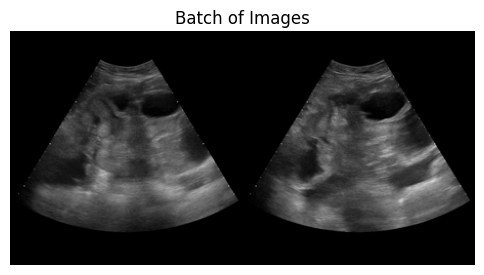

In [ ]:
# 샘플 배치 출력(참고)
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

batched = torch.stack(imgs)            # -> Tensor of shape (B, 3, 224, 224)
grid_img = make_grid(batched, nrow=2)

plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1,2,0))  # (H,W,C)로 변환
plt.axis('off')
plt.title("Batch of Images")
plt.show()

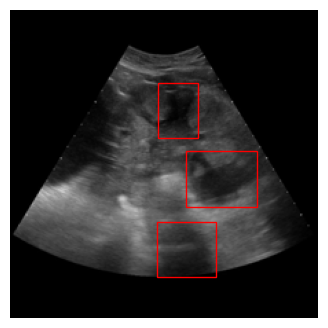

In [ ]:
# 바운딩박스 시각화(참고)

fig, ax = plt.subplots(1,1, figsize=(4,4))
img0 = imgs[0].permute(1,2,0).numpy()  # (H,W,C)
ax.imshow(img0)
for (x1,y1,x2,y2) in targets[0]['boxes']:
    rect = plt.Rectangle((x1,y1), x2-x1, y2-y1,
                         edgecolor='r', facecolor='none', linewidth=1)
    ax.add_patch(rect)
ax.axis('off')
plt.show()

## 02. 학습

### 디바이스 설정(GPU)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"사용 디바이스: {device}")

사용 디바이스: cuda


### 하이퍼파라미터 설정

In [ ]:
class_num = 2        # 클래스 개수: torchvison에서는 0은 배경으로 고정이기 때문에 클래스 개수 + 1
batch_size = 4         # 배치 크기
learning_rate = 0.001    # 학습률
num_epochs = 10           # 에포크 수

### 데이터셋 로드

데이터셋을 불러와 학습에 이용할 수 있도록 train/val로 나눠줍니다.

In [ ]:
# 필요 라이브러리

import torch
from torch.utils.data import random_split, DataLoader

(1) 데이터셋 불러오기

In [ ]:
dataset = PigDataset('/content/gdrive/MyDrive/rda-colab/양돈과_최요한')

(2) train/val split

In [ ]:
# split 크기(8:2 비율--조정 가능)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size   = total_size - train_size

# 랜덤 스플릿
train_ds, val_ds = random_split(
    dataset,
    [train_size, val_size]
)

(3) 데이터 로더 생성

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,     # validation은 shuffle=False 권장
    collate_fn=collate_fn
)

(4) 확인

In [ ]:
print(f"전체 샘플: {total_size}")
print(f"Train 샘플: {len(train_ds)}, Val 샘플: {len(val_ds)}")

# 샘플 배치
images, targets = next(iter(train_loader))
print("Train batch 이미지 개수:", len(images))
print("첫 이미지 tensor shape:", images[0].shape)
print("첫 이미지 박스 개수:", targets[0]['boxes'].shape[0])

전체 샘플: 132
Train 샘플: 105, Val 샘플: 27
Train batch 이미지 개수: 4
첫 이미지 tensor shape: torch.Size([3, 224, 224])
첫 이미지 박스 개수: 3


### 모델 로드

토치비전에서 제공하는 사전학습된 Faster R-CNN 모델을 이용합니다.

`torchvision.models` 라이브러리에서 불러옵니다.

In [ ]:
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
# ResNet-50을 백본으로 하는 Faster R-CNN
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 사용 데이터에 맞게 헤더 변경
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=class_num)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# GPU에 올리기
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Optimzier 설정

In [ ]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=0.0005
)

### 학습

각 epoch마다 학습과 검증을 반복하고 관찰하겠습니다.

In [ ]:
import tqdm

In [ ]:

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Train ------------------------

    model.train() # train 모드

    epoch_loss = 0.0
    for images, targets in tqdm.tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", ncols=100):
        # device로 옮기기
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # forward pass & loss dict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # backward & update
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation ---------------------

    epoch_val_loss = 0.0
    with torch.no_grad(): # eval에서는 gradient 계산 안함
        for images, targets in tqdm.tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", ncols=100):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")


[Val]   Epoch 1/10: 100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s]


Epoch 1/10  Train Loss: 0.4275  Val Loss: 0.4615


[Val]   Epoch 2/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.63it/s]


Epoch 2/10  Train Loss: 0.3129  Val Loss: 0.3579


[Val]   Epoch 3/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 3/10  Train Loss: 0.2366  Val Loss: 0.3055


[Val]   Epoch 4/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch 4/10  Train Loss: 0.1965  Val Loss: 0.2888


[Val]   Epoch 5/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch 5/10  Train Loss: 0.1707  Val Loss: 0.3231


[Val]   Epoch 6/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


Epoch 6/10  Train Loss: 0.1601  Val Loss: 0.2865


[Val]   Epoch 7/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch 7/10  Train Loss: 0.1424  Val Loss: 0.2936


[Val]   Epoch 8/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.73it/s]


Epoch 8/10  Train Loss: 0.1264  Val Loss: 0.2922


[Val]   Epoch 9/10: 100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  2.71it/s]


Epoch 9/10  Train Loss: 0.1097  Val Loss: 0.2898


[Val]   Epoch 10/10: 100%|████████████████████████████████████████████| 7/7 [00:02<00:00,  2.66it/s]

Epoch 10/10  Train Loss: 0.1086  Val Loss: 0.2933


Loss curve

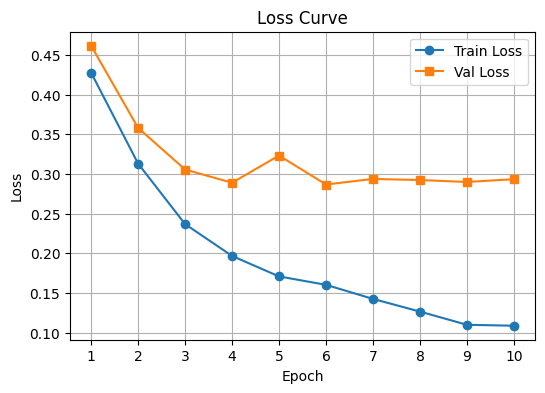

In [ ]:
plt.figure(figsize=(6,4))
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()

- 0에 수렴하는 training loss와 달리 validation loss는 감소하지 않습니다.

  -> 학습데이터에 과도하게 학습된 **오버피팅(Overfitting)**이 발생했습니다.

- 오버피팅은 다른 노트북에서 다룹니다.

### 평가

검증집합을 이용해 모델을 평가합니다.

검출은 보통 AP(Average precision)을 이용하지만, 여기서는 precision과 recall만 평가합니다.

(AP는 별도 라이브러리 및 데이터 변환 필요)

정답과 예측 박스의 IoU 및 confidence score가 임계값 이상이면 True로 판단합니다.

In [ ]:
import torch
from torchvision.ops import box_iou

In [ ]:
def evaluate_dataset(model, data_loader, device, iou_thresh=0.5, score_thresh=0.5):
    """
    모델과 DataLoader를 받아 Validation Precision & Recall 계산.
    """
    tp = fp = fn = 0
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images   = [img.to(device) for img in images]
            gt_boxes = [t['boxes'].to(device) for t in targets]
            gt_labels= [t['labels'].to(device) for t in targets]

            outputs = model(images)
            for output, gt_b, gt_l in zip(outputs, gt_boxes, gt_labels):
                tidx = output['scores'] >= score_thresh
                pred_boxes  = output['boxes'][tidx]
                pred_labels = output['labels'][tidx]

                # 1) GT가 없으면, 모든 예측은 False Positive
                if gt_b.numel() == 0:
                    fp += pred_boxes.shape[0]
                    continue
                # 2) 예측이 없으면, 모든 GT는 False Negative
                if pred_boxes.numel() == 0:
                    fn += gt_b.shape[0]
                    continue

                # 3) IoU 매트릭스 계산
                ious = box_iou(pred_boxes, gt_b)  # [P, G]

                # 4) 예측 박스마다 TP/FP 결정
                matched_gt = torch.zeros(gt_b.size(0), dtype=torch.bool, device=device)
                for i in range(pred_boxes.size(0)):
                    max_iou, idx = ious[i].max(0)
                    if max_iou >= iou_thresh and pred_labels[i] == gt_l[idx]:
                        tp += 1
                        matched_gt[idx] = True
                    else:
                        fp += 1
                # 5) 매칭되지 않은 GT는 FN
                fn += (~matched_gt).sum().item()

    precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0
    return precision, recall


In [ ]:
precision, recall = evaluate_dataset(model, val_loader, device)

In [ ]:
print(f"Precision: {precision:.4f}  Recall: {recall:.4f}")

Precision: 0.8148  Recall: 0.8571


### 모델 저장

In [ ]:
torch.save(model.state_dict(), '/content/faster_rcnn_pig.pth')

## 추론(Inference)

검증 셋의 이미지를 한 장 불러와 학습한 모델로 타겟을 검출해보겠습니다.

이미지 로드

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image

In [ ]:
dataset.img_files[val_ds.indices[0]]

'/content/gdrive/MyDrive/rda-colab/양돈과_최요한/25_1/001_W5741__2021-10-12_10_01_06_frame0030.bmp'

In [ ]:
# 이미지 로드
img_path = dataset.img_files[val_ds.indices[0]]
img = Image.open(img_path).convert("RGB")

In [ ]:
# 학습과 동일한 transform 적용 및 텐서 변환
transform = T.Compose([T.Resize((224,224)), T.ToTensor()])
img_tensor = transform(img).unsqueeze(0).to(device)

예측

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)[0]

score_thr = 0.5
# confidence score 기준 이상의 결과만 남김
idx = outputs['scores'] >= score_thr
boxes  = outputs['boxes'][idx].cpu()
labels = outputs['labels'][idx].cpu()
scores = outputs['scores'][idx].cpu()

시각화

In [ ]:
import matplotlib.pyplot as plt

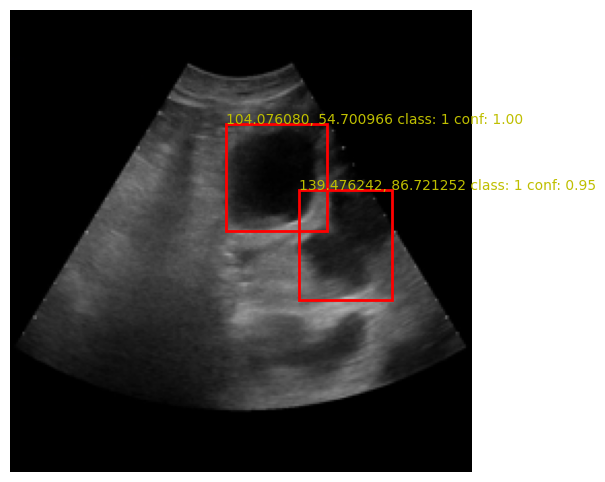

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(img.resize((224,224)))
ax = plt.gca()
for bbox, label, scr in zip(boxes, labels, scores):
    x1,y1,x2,y2 = bbox
    ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                edgecolor='r', facecolor='none', linewidth=2))
    ax.text(x1, y1, f"{x1:1f}, {y1:2f} class: {label.item()} conf: {scr:.2f}", color='y')
plt.axis('off')
plt.show()

## 저장한 모델 사용하기

학습한 모델을 불러와 사용합니다.

위 코드에서 torch.save(model.state_dict(), '/content/faster_rcnn_pig.pth')로 저장한 모델을 사용하겠습니다.

In [ ]:
# 라이브러리
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from google.colab import files

학습한 모델과 동일한 구조를 재생성합니다.

In [ ]:
def get_model(num_classes=2):
    # COCO 사전학습 Faster R-CNN + ResNet50 FPN 불러오기
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # box_predictor 교체 (배경 + 돼지)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

모델 로드

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes=2)
state_dict = torch.load('/content/faster_rcnn_pig.pth', map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

이미지 업로드

In [ ]:
print("이미지 파일을 업로드하세요.")
uploaded = files.upload()  # 브라우저에서 파일 선택
image_path = next(iter(uploaded.keys()))

이미지 파일을 업로드하세요.


Saving 001_W5741__2021-10-12_10_01_06_frame0007.bmp to 001_W5741__2021-10-12_10_01_06_frame0007.bmp


이미지 전처리 정의(모델 입력과 동일)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

단일 이미지 추론

In [ ]:
img = Image.open(image_path).convert("RGB")
img_resized = transform(img).unsqueeze(0).to(device)  # [1,3,224,224]
with torch.no_grad():
    output = model(img_resized)[0]

결과 필터링

In [ ]:
score_thr = 0.5
idx = outputs['scores'] >= score_thr
boxes  = outputs['boxes'][idx].cpu()
labels = outputs['labels'][idx].cpu()
scores = outputs['scores'][idx].cpu()

시각화

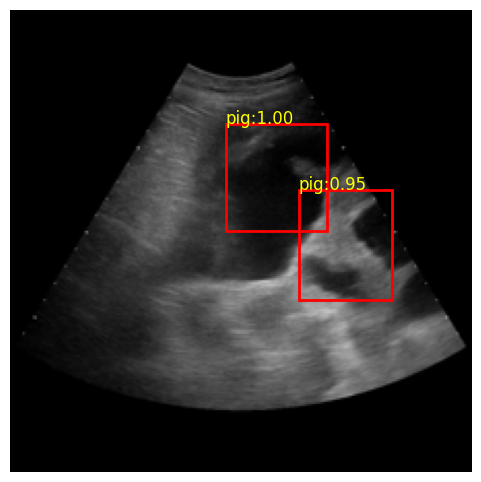

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(img.resize((224,224)))
ax = plt.gca()
for box, lbl, scr in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                               edgecolor='r', facecolor='none', linewidth=2))
    ax.text(x1, y1, f"pig:{scr:.2f}", color='yellow', fontsize=12)
plt.axis('off')
plt.show()